# Agentic AI for Investment Research and Market Analysis
**Course:** AAI-520 — Final Team Project  
**Team:** 11 | **Members:** Sowrab R Iyengar (Lead), Pratibha Kambi, Antareep Chakrobarty  
**GitHub Link:** https://github.com/usd-aai-sri/AAI520_AgenticAI_Finance

This notebook preserves the original code and minimally **builds on it** with clear sections, markdown explanations, and small additive utilities to satisfy the project **Agent Functions**, **Workflow Patterns**, and **Code** requirements.

---

## Project Overview
We implement an **Investment Research Agent** that:
- Plans research steps for a given stock symbol.
- Uses tools dynamically (Yahoo Finance, News ingestion, FRED).
- Self-reflects on outputs (**Evaluator–Optimizer** loop).
- Retains lightweight memory across runs to improve future analyses.

## Workflow Patterns Demonstrated
1. **Prompt Chaining:** Ingest News → Preprocess → Classify → Extract → Summarize  
2. **Routing:** Direct items to specialist analyzers (news, earnings, macro).  
3. **Evaluator–Optimizer:** Generate → Evaluate quality → Refine using feedback.

> **Note:** API keys are referenced via environment variables. This notebook does not make network calls during export; use your keys and run cells locally/colab.


## Setup and Imports
This section imports the necessary Python libraries required for data processing, visualization, and API integration.

In [3]:

# !pip install -q yfinance pandas numpy scikit-learn matplotlib textblob nltk newsapi-python fredapi sec-edgar-downloader


In [1]:
import os
import json
import time
import math
import uuid
import string
import random
import pandas as pd
import numpy as np
import yfinance as yf

# Optional imports (guarded)
try:
    from newsapi import NewsApiClient
except Exception:
    NewsApiClient = None

try:
    from fredapi import Fred
except Exception:
    Fred = None

# Plotting defaults
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 120)


## Configuration and Memory
Configuration parameters and lightweight persistent memory are defined here to enable consistent runs and iterative improvement.

In [2]:
# --- Configuration & Lightweight Memory ---
TICKER = os.getenv("PROJECT_TICKER", "AAPL")
LOOKBACK_DAYS = int(os.getenv("LOOKBACK_DAYS", "365"))
NEWS_WINDOW_DAYS = int(os.getenv("NEWS_WINDOW_DAYS", "14"))
RISK_FREE_RATE = float(os.getenv("RISK_FREE_RATE", "0.045"))  # annualized

MEMO_PATH = os.getenv("AGENT_MEMO_PATH", "agent_memo.json")

def load_memo(path=MEMO_PATH):
    if os.path.exists(path):
        try:
            with open(path, "r", encoding="utf-8") as f:
                return json.load(f)
        except Exception:
            return {}
    return {}

def save_memo(memo, path=MEMO_PATH):
    try:
        with open(path, "w", encoding="utf-8") as f:
            json.dump(memo, f, indent=2)
    except Exception as e:
        print("Memo save failed:", e)

MEMO = load_memo()
MEMO.setdefault("run_notes", [])
MEMO.setdefault("tickers_seen", {})


{}

## Tools for Price Data and Feature Engineering
This section defines helper functions to retrieve market data from Yahoo Finance and compute basic statistical features for analysis.

In [3]:
# --- Tool: Yahoo Finance Price & Fundamentals Fetch ---
from datetime import datetime, timedelta

def fetch_price_history(ticker=TICKER, days=LOOKBACK_DAYS):
    end = datetime.utcnow().date()
    start = end - timedelta(days=days)
    df = yf.download(ticker, start=start.isoformat(), end=end.isoformat(), progress=False)
    df = df.rename(columns={"Adj Close": "AdjClose"})
    return df

def basic_features(price_df: pd.DataFrame) -> pd.DataFrame:
    df = price_df.copy()
    df["Return"] = df["AdjClose"].pct_change()
    df["Volatility20"] = df["Return"].rolling(window=20).std() * np.sqrt(252)
    df["SMA20"] = df["AdjClose"].rolling(window=20).mean()
    df["SMA50"] = df["AdjClose"].rolling(window=50).mean()
    df["Momentum20"] = df["AdjClose"].pct_change(periods=20)
    return df


## Workflow Pattern 1 — Prompt Chaining
This section demonstrates how the agent processes financial news in a sequence of steps: ingestion, preprocessing, classification, extraction, and summarization.

In [4]:
# --- Tool: News Ingestion (Placeholder for NewsAPI/Kaggle) ---
from datetime import datetime, timedelta

def ingest_news(ticker=TICKER, window_days=NEWS_WINDOW_DAYS):
    """Return a placeholder dataframe of 'news' with minimal schema.
    Replace with actual NewsAPI/Kaggle ingestion in production.
    """
    end = datetime.utcnow().date()
    start = end - timedelta(days=window_days)
    data = [
        {
            "date": str(start + timedelta(days=i)),
            "title": f"{ticker} sample headline {i}",
            "content": f"Placeholder news content about {ticker} event {i}. Earnings, guidance, or product updates.",
            "source": "PlaceholderWire"
        }
        for i in range(window_days)
    ]
    return pd.DataFrame(data)

def preprocess_news(df: pd.DataFrame) -> pd.DataFrame:
    # Minimal cleanup/token count for demonstration
    df = df.copy()
    df["len"] = df["content"].fillna("").str.len()
    df["lower"] = df["content"].fillna("").str.lower()
    return df

def classify_news(df: pd.DataFrame) -> pd.DataFrame:
    # Very naive rule-based 'classification' (replace with model)
    df = df.copy()
    df["class"] = np.where(df["lower"].str.contains("earnings|guidance|record|beat"), "fundamental",
                   np.where(df["lower"].str.contains("product|launch|update"), "product",
                   "general"))
    return df

def extract_signals(df: pd.DataFrame) -> pd.DataFrame:
    # Toy 'signal': positive if 'record' or 'beat' appears
    df = df.copy()
    pos = df["lower"].str.contains("record|beat|raise|upgrade")
    neg = df["lower"].str.contains("downgrade|cut|miss|delay")
    df["signal"] = np.select([pos, neg], [1, -1], default=0)
    return df

def summarize_findings(df: pd.DataFrame) -> str:
    counts = df["class"].value_counts(dropna=False).to_dict()
    sentiment = int(df["signal"].sum())
    s = [
        f"News classes: {counts}",
        f"Cumulative directional signal (toy): {sentiment:+d}",
        "Key observations:",
        "- Fundamental items imply earnings/guidance sensitivity.",
        "- Product items may impact medium-term momentum.",
        "- General items provide background context."
    ]
    return "\n".join(s)


## Workflow Pattern 2 — Routing
Routing ensures that content is directed to specialized analyzers based on its characteristics, such as earnings reports, macroeconomic updates, or general news.

In [5]:
# --- Routing: Send items to the right specialist analyzer ---
def route_item(item: dict) -> str:
    text = (item.get("title","") + " " + item.get("content","")).lower()
    if any(k in text for k in ["earnings","guidance","revenue","profit","margin"]):
        return "earnings_analyzer"
    if any(k in text for k in ["cpi","rates","employment","fomc","gdp","inflation"]):
        return "macro_analyzer"
    return "news_analyzer"

def apply_routing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["route"] = df.apply(route_item, axis=1)
    return df


## Workflow Pattern 3 — Evaluator–Optimizer
The Evaluator–Optimizer framework enables self-critique and iterative refinement. The agent evaluates the quality of its own output and refines it using feedback to achieve a more coherent and complete analysis.

In [6]:
# --- Evaluator–Optimizer: Self-critique and refinement loop ---
def generate_analysis(ticker, price_df, news_df) -> str:
    last_close = float(price_df["AdjClose"].iloc[-1])
    vol = float(price_df["Volatility20"].iloc[-1])
    news_summary = summarize_findings(news_df)
    draft = f"""Analysis v1 for {ticker}:
- Last close: {last_close:.2f}
- 20D annualized volatility: {vol:.2%}
- News summary:
{news_summary}

Initial view: Blend of fundamentals and product updates in recent cycle.
"""
    return draft

def evaluate_quality(text: str) -> dict:
    # Toy evaluator: length, key sections present
    score = 0
    checks = {}
    checks["has_last_close"] = "Last close" in text
    checks["has_volatility"] = "volatility" in text.lower()
    checks["has_news_summary"] = "News summary" in text
    score = sum(int(v) for v in checks.values())
    return {"score": score, "checks": checks}

def refine_with_feedback(text: str, eval_report: dict) -> str:
    s = text
    if not eval_report["checks"].get("has_last_close", False):
        s += "\nAdded: Include last close figure."
    if not eval_report["checks"].get("has_volatility", False):
        s += "\nAdded: Include 20D annualized volatility."
    if not eval_report["checks"].get("has_news_summary", False):
        s += "\nAdded: Attach news summary block."
    s += "\nRefinement note: Consider adding risk perspective vs. risk-free rate."
    return s


## Agent Planner and Orchestrator
This component defines the sequence of research actions executed by the agent, integrating all workflow patterns to perform a full financial analysis autonomously.

In [7]:
# --- Planner: Research Steps ---
PLAN_STEPS = [
    "Fetch price history",
    "Engineer basic features (returns, vol, SMAs)",
    "Ingest & preprocess recent news",
    "Classify and extract directional signals",
    "Route items to specialist analyzers",
    "Synthesize draft analysis",
    "Evaluate and refine analysis (Evaluator–Optimizer)",
    "Persist brief memory and results"
]

def run_agent(ticker=TICKER):
    print("Plan:", *[f"{i+1}. {s}" for i,s in enumerate(PLAN_STEPS)], sep="\n")
    prices = fetch_price_history(ticker)
    feats = basic_features(prices)
    news = ingest_news(ticker)
    news_p = preprocess_news(news)
    news_c = classify_news(news_p)
    news_s = extract_signals(news_c)
    news_r = apply_routing(news_s)

    draft = generate_analysis(ticker, feats.dropna(), news_r)
    eval_report = evaluate_quality(draft)
    refined = refine_with_feedback(draft, eval_report)

    # Persist brief memory
    MEMO["tickers_seen"].setdefault(ticker, 0)
    MEMO["tickers_seen"][ticker] += 1
    MEMO["run_notes"].append({
        "ticker": ticker,
        "ts": time.time(),
        "eval_score": eval_report["score"]
    })
    save_memo(MEMO)

    return {
        "prices": prices,
        "features": feats,
        "news": news_r,
        "draft": draft,
        "evaluation": eval_report,
        "refined": refined
    }

# Example (safe to run offline with placeholder news)
# results = run_agent(TICKER)
# print(results["refined"][:800])


## Reporting
Visualization functions are included to display results and highlight key financial indicators such as adjusted closing prices and moving averages.

In [8]:
# --- Reporting Helpers ---
def plot_prices_and_sma(df: pd.DataFrame, ticker=TICKER):
    df = df.dropna(subset=["AdjClose"])
    plt.figure(figsize=(10,4))
    df["AdjClose"].plot(label=f"{ticker} AdjClose")
    if "SMA20" in df: df["SMA20"].plot(label="SMA20")
    if "SMA50" in df: df["SMA50"].plot(label="SMA50")
    plt.title(f"{ticker} Price with SMAs")
    plt.legend()
    plt.grid(True)
    plt.show()

# To use after run_agent:
# plot_prices_and_sma(results["features"])


#DATA COLLECTION

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

In [10]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from fredapi import Fred

# --- Default Settings ---
DEFAULT_TICKER = "RELIANCE.NS"
DEFAULT_PERIOD = "5y"
SUGGESTED_TICKERS = [
    "RELIANCE.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", "TCS.NS",
    "SBIN.NS", "LT.NS", "BHARTIARTL.NS", "ITC.NS", "ASIANPAINT.NS"
]
FRED_API_KEY = '5f43b12d79e8665de611dd3d44b0e714'  # Replace with your key

# --- Data Extraction Functions ---

# Yahoo Finance Stock Prices
def generate_synthetic_stock_data(ticker=DEFAULT_TICKER, days=1260):
    dates = pd.date_range(end=datetime.today(), periods=days, freq='B')
    df = pd.DataFrame({
        'Date': dates,
        'Open': np.random.uniform(100, 200, size=days),
        'High': np.random.uniform(200, 300, size=days),
        'Low': np.random.uniform(50, 100, size=days),
        'Close': np.random.uniform(100, 200, size=days),
        'Adj Close': np.random.uniform(100, 200, size=days),
        'Volume': np.random.randint(1000000, 5000000, size=days),
        'Ticker': ticker
    })
    return df

def get_yfinance_data(ticker=DEFAULT_TICKER, period=DEFAULT_PERIOD, synthetic_days=1260):
    """Fetch stock data for a single ticker"""
    try:
        df = yf.download(ticker, period=period, progress=False, auto_adjust=False)
        if df.empty:
            raise ValueError("No data returned")
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        df = df.reset_index()
        required_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        for col in required_cols:
            if col not in df.columns:
                df[col] = np.nan
        df = df[required_cols]
        df['Ticker'] = ticker
        print(f"Yahoo Finance data fetched for {ticker}")
    except Exception as e:
        print(f"Yahoo Finance error for {ticker}: {e}. Generating synthetic data.")
        df = generate_synthetic_stock_data(ticker=ticker, days=synthetic_days)
    return df

# SEC EDGAR Filings
def get_sec_edgar_filings(ticker=DEFAULT_TICKER, filings_per_ticker=5):
    form_types = ['10-K', '10-Q', '8-K', 'S-1', 'DEF 14A']
    mock_filings = []
    for i in range(filings_per_ticker):
        filing_date = datetime.today() - timedelta(days=np.random.randint(1, 365))
        form_type = np.random.choice(form_types)
        mock_filings.append({
            'Ticker': ticker,
            'FilingDate': filing_date,
            'FormType': form_type,
            'Title': f"{ticker} {form_type} Filing",
            'Summary': f"Summary of {form_type} filing for {ticker}.",
            'FilingLink': f"https://www.sec.gov/Archives/edgar/data/{ticker}/{i}",
            'Source': 'SEC EDGAR'
        })
    return pd.DataFrame(mock_filings)

# Mock Kaggle-style Financial News
def get_kaggle_financial_news_mock(ticker= DEFAULT_TICKER, days=1825):
    """
    Generate mock financial news for multiple tickers.

    Args:
        tickers (list): List of ticker symbols to generate news for.
        days (int): Number of past days to generate news (default 2 years ~ 730 days).

    Returns:
        pd.DataFrame: Mock financial news dataset with columns ['Ticker', 'Date', 'Headline', 'Category']
    """
    news_data = []
    for ticker in ticker:
        for i in range(days):
            news_data.append({
                'Ticker': ticker,
                'Date': datetime.today() - timedelta(days=i),
                'Headline': f"Kaggle mock news {i+1} for {ticker}",
                'Category': np.random.choice(['Economy', 'Company', 'Market']),
            })
    return pd.DataFrame(news_data)


# FRED Economic Data
def get_fred_economic_data(series_id, years=5):
    """Fetch economic data for the past N years from FRED API"""
    end_date = datetime.today().strftime('%Y-%m-%d')
    start_date = (datetime.today() - pd.DateOffset(years=years)).strftime('%Y-%m-%d')

    try:
        fred = Fred(api_key=FRED_API_KEY)
        data = fred.get_series(series_id, start_date, end_date)
        df = pd.DataFrame(data, columns=[series_id])
        df['Date'] = df.index
        df.set_index('Date', inplace=True)
        print(f"FRED data fetched for {series_id} ({start_date} to {end_date})")
        return df
    except Exception as e:
        print(f"FRED API error for {series_id}: {e}")
        return pd.DataFrame()


# --- Execute Extraction Pipeline with SUGGESTED_TICKERS ---

# Yahoo Finance for all suggested tickers
all_stock_data = [get_yfinance_data(ticker=t) for t in SUGGESTED_TICKERS]
combined_stock_df = pd.concat(all_stock_data, ignore_index=True)
print("=== Stock Data ===")
print(combined_stock_df.head())

# SEC Filings for all suggested tickers
all_sec_filings = [get_sec_edgar_filings(ticker=t) for t in SUGGESTED_TICKERS]
sec_filings_df = pd.concat(all_sec_filings, ignore_index=True)
print("=== SEC Filings ===")
print(sec_filings_df.head())

# Mock Kaggle News for all suggested tickers
all_news_data = [get_kaggle_financial_news_mock(ticker=t) for t in SUGGESTED_TICKERS]
mock_kaggle_news_df = pd.concat(all_news_data, ignore_index=True)
print("=== Kaggle News ===")
print(mock_kaggle_news_df.head())

# FRED Economic Data
gdp_df = get_fred_economic_data('GDPC1')
unemployment_rate_df = get_fred_economic_data('UNRATE')
cpi_df = get_fred_economic_data('CPIAUCSL')

economic_df = gdp_df.join([unemployment_rate_df, cpi_df], how='outer')
economic_df = economic_df.sort_index().ffill().infer_objects(copy=False)
print("=== Economic Data ===")
print(economic_df.head())



Yahoo Finance data fetched for RELIANCE.NS
Yahoo Finance data fetched for HDFCBANK.NS
Yahoo Finance data fetched for ICICIBANK.NS
Yahoo Finance data fetched for INFY.NS
Yahoo Finance data fetched for TCS.NS
Yahoo Finance data fetched for SBIN.NS
Yahoo Finance data fetched for LT.NS
Yahoo Finance data fetched for BHARTIARTL.NS
Yahoo Finance data fetched for ITC.NS
Yahoo Finance data fetched for ASIANPAINT.NS
=== Stock Data ===
Price       Date         Open         High          Low        Close  \
0     2020-10-16  1022.222168  1030.298340  1002.677612  1004.131348   
1     2020-10-19  1010.707703  1028.544678   994.601379  1004.315918   
2     2020-10-20  1005.608154  1012.069153   993.263000   994.947510   
3     2020-10-21  1000.531677  1011.607666   968.111267   980.502563   
4     2020-10-22   981.794739   984.148376   964.996155   972.357056   

Price   Adj Close    Volume       Ticker  
0      986.575684  21583600  RELIANCE.NS  
1      986.757080  31200385  RELIANCE.NS  
2      9

#DATA MERGE

In [12]:
# Ensure correct datatypes
combined_stock_df['Date'] = pd.to_datetime(combined_stock_df['Date'])
mock_kaggle_news_df['Date'] = pd.to_datetime(mock_kaggle_news_df['Date'])
combined_stock_df['Ticker'] = combined_stock_df['Ticker'].astype(str)
mock_kaggle_news_df['Ticker'] = mock_kaggle_news_df['Ticker'].astype(str)

# Aggregate news by Ticker + Date
daily_news_count = (
    mock_kaggle_news_df.groupby(['Ticker', 'Date'])
    .size()
    .reset_index(name='NewsCount')
)

# Merge stock with news
stock_news_df = pd.merge(
    combined_stock_df,
    daily_news_count,
    on=['Ticker', 'Date'],
    how='left'
)

# Fill NaNs in news
stock_news_df['NewsCount'] = stock_news_df['NewsCount'].fillna(0).astype(int)

print("✅ Step 1 done: Stock + News merged")
print(stock_news_df.head())


✅ Step 1 done: Stock + News merged
        Date         Open         High          Low        Close   Adj Close  \
0 2020-10-16  1022.222168  1030.298340  1002.677612  1004.131348  986.575684   
1 2020-10-19  1010.707703  1028.544678   994.601379  1004.315918  986.757080   
2 2020-10-20  1005.608154  1012.069153   993.263000   994.947510  977.552490   
3 2020-10-21  1000.531677  1011.607666   968.111267   980.502563  963.360046   
4 2020-10-22   981.794739   984.148376   964.996155   972.357056  955.356995   

     Volume       Ticker  NewsCount  
0  21583600  RELIANCE.NS          0  
1  31200385  RELIANCE.NS          0  
2  18482288  RELIANCE.NS          0  
3  34082321  RELIANCE.NS          0  
4  30802210  RELIANCE.NS          0  


In [13]:
# Convert filing date
sec_filings_df['FilingDate'] = pd.to_datetime(sec_filings_df['FilingDate'])
sec_filings_df['Ticker'] = sec_filings_df['Ticker'].astype(str)

# Sort data for merge_asof
stock_news_sorted = stock_news_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
filings_sorted = sec_filings_df.sort_values(['Ticker', 'FilingDate']).reset_index(drop=True)

merged_slices = []
for ticker in stock_news_sorted['Ticker'].unique():
    stock_t = stock_news_sorted[stock_news_sorted['Ticker'] == ticker]
    filings_t = filings_sorted[filings_sorted['Ticker'] == ticker]

    if not filings_t.empty:
        merged = pd.merge_asof(
            stock_t.sort_values('Date'),
            filings_t.drop(columns=['Ticker'], errors='ignore').sort_values('FilingDate'),
            left_on='Date',
            right_on='FilingDate',
            direction='backward'
        )
    else:
        merged = stock_t.copy()
        merged['FilingDate'] = pd.NaT
        merged['FormType'] = np.nan
        merged['Title'] = np.nan
        merged['Summary'] = np.nan
        merged['FilingLink'] = np.nan
        merged['Source'] = np.nan

    merged['Ticker'] = ticker
    merged_slices.append(merged)

stock_news_filings_df = pd.concat(merged_slices, ignore_index=True)

print("✅ Step 2 done: Stock + News + Filings merged")
print(stock_news_filings_df.head())


✅ Step 2 done: Stock + News + Filings merged
        Date         Open         High          Low        Close    Adj Close  \
0 2020-10-16  2089.949951  2090.000000  2055.550049  2061.199951  1972.988525   
1 2020-10-19  2079.949951  2079.949951  2056.500000  2070.100098  1981.507568   
2 2020-10-20  2077.899902  2131.800049  2067.350098  2118.500000  2027.835693   
3 2020-10-21  2130.000000  2143.850098  2081.250000  2114.300049  2023.816284   
4 2020-10-22  2114.199951  2116.850098  2076.800049  2099.899902  2010.032104   

    Volume         Ticker  NewsCount FilingDate FormType Title Summary  \
0  2017706  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   
1  1338404  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   
2  2377713  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   
3  2895432  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   
4  2755686  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   

  FilingLink Source  
0

In [15]:
# Reset index and ensure Date column
economic_df_sorted = economic_df.sort_index().ffill().reset_index().rename(columns={'index':'Date'})
economic_df_sorted['Date'] = pd.to_datetime(economic_df_sorted['Date'])

# Sort left dataframe
stock_news_filings_sorted = stock_news_filings_df.sort_values('Date').reset_index(drop=True)

# Merge using merge_asof
master_df = pd.merge_asof(
    stock_news_filings_sorted,
    economic_df_sorted,
    on='Date',
    direction='backward'
)

print("Step 3 done: Added economic indicators")
print(master_df.head())
print("Columns in master dataset:", master_df.columns.tolist())


Step 3 done: Added economic indicators
        Date         Open         High          Low        Close    Adj Close  \
0 2020-10-16  2089.949951  2090.000000  2055.550049  2061.199951  1972.988525   
1 2020-10-16   194.000000   196.750000   191.600006   195.949997   180.806305   
2 2020-10-16  1022.222168  1030.298340  1002.677612  1004.131348   986.575684   
3 2020-10-16   894.000000   903.500000   889.500000   894.099976   832.335388   
4 2020-10-16  2750.100098  2771.649902  2731.300049  2763.300049  2468.614746   

     Volume         Ticker  NewsCount FilingDate FormType Title Summary  \
0   2017706  ASIANPAINT.NS          0        NaT      NaN   NaN     NaN   
1  36893126        SBIN.NS          0        NaT      NaN   NaN     NaN   
2  21583600    RELIANCE.NS          0        NaT      NaN   NaN     NaN   
3   2373435          LT.NS          0        NaT      NaN   NaN     NaN   
4   5273773         TCS.NS          0        NaT      NaN   NaN     NaN   

  FilingLink Source    

In [17]:
# Ensure correct datatypes
combined_stock_df['Date'] = pd.to_datetime(combined_stock_df['Date'])
mock_kaggle_news_df['Date'] = pd.to_datetime(mock_kaggle_news_df['Date'])
combined_stock_df['Ticker'] = combined_stock_df['Ticker'].astype(str)
mock_kaggle_news_df['Ticker'] = mock_kaggle_news_df['Ticker'].astype(str)

# Aggregate news by Ticker + Date
daily_news_count = (
    mock_kaggle_news_df.groupby(['Ticker', 'Date'])
    .size()
    .reset_index(name='NewsCount')
)

# Merge stock with news
stock_news_df = pd.merge(
    combined_stock_df,
    daily_news_count,
    on=['Ticker', 'Date'],
    how='left'
)

# Fill NaNs in news
stock_news_df['NewsCount'] = stock_news_df['NewsCount'].fillna(0).astype(int)

print("Step 1 done: Stock + News merged")
print(stock_news_df.head())


Step 1 done: Stock + News merged
        Date         Open         High          Low        Close   Adj Close  \
0 2020-10-16  1022.222168  1030.298340  1002.677612  1004.131348  986.575684   
1 2020-10-19  1010.707703  1028.544678   994.601379  1004.315918  986.757080   
2 2020-10-20  1005.608154  1012.069153   993.263000   994.947510  977.552490   
3 2020-10-21  1000.531677  1011.607666   968.111267   980.502563  963.360046   
4 2020-10-22   981.794739   984.148376   964.996155   972.357056  955.356995   

     Volume       Ticker  NewsCount  
0  21583600  RELIANCE.NS          0  
1  31200385  RELIANCE.NS          0  
2  18482288  RELIANCE.NS          0  
3  34082321  RELIANCE.NS          0  
4  30802210  RELIANCE.NS          0  


In [19]:
# Define the path
save_path = "./master_investment_dataset.csv"

# Save the DataFrame
master_df.to_csv(save_path, index=False)

print(f"master_df has been saved to '{save_path}'")


master_df has been saved to './master_investment_dataset.csv'


# DATA PRE-PROCESSING

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re


# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [21]:
#Read the dataset
df = pd.read_csv("./master_investment_dataset.csv")

In [22]:
#List of features in a dataset
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'NewsCount', 'FilingDate', 'FormType', 'Title', 'Summary', 'FilingLink',
       'Source', 'GDPC1', 'UNRATE', 'CPIAUCSL'],
      dtype='object')

In [23]:
df.info(())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12380 entries, 0 to 12379
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        12380 non-null  object 
 1   Open        12380 non-null  float64
 2   High        12380 non-null  float64
 3   Low         12380 non-null  float64
 4   Close       12380 non-null  float64
 5   Adj Close   12380 non-null  float64
 6   Volume      12380 non-null  int64  
 7   Ticker      12380 non-null  object 
 8   NewsCount   12380 non-null  int64  
 9   FilingDate  2089 non-null   object 
 10  FormType    2089 non-null   object 
 11  Title       2089 non-null   object 
 12  Summary     2089 non-null   object 
 13  FilingLink  2089 non-null   object 
 14  Source      2089 non-null   object 
 15  GDPC1       12380 non-null  float64
 16  UNRATE      12380 non-null  float64
 17  CPIAUCSL    12380 non-null  float64
dtypes: float64(8), int64(2), object(8)
memory usage: 1.7+ MB


In [24]:
df = df.rename(columns={
    "Source": "DataSource",
    "GDPC1": "RealGDP",
    "UNRATE": "UnemploymentRate",
    "CPIAUCSL": "ConsumerPriceIndex"
})

In [25]:
#Check for null values in the datset
df.isna().sum()

Date                      0
Open                      0
High                      0
Low                       0
Close                     0
Adj Close                 0
Volume                    0
Ticker                    0
NewsCount                 0
FilingDate            10291
FormType              10291
Title                 10291
Summary               10291
FilingLink            10291
DataSource            10291
RealGDP                   0
UnemploymentRate          0
ConsumerPriceIndex        0
dtype: int64

In [26]:
df_final = df.copy()

In [28]:
df_final.shape

(12380, 18)

In [29]:
# Ensure FilingDate is datetime
df_final['FilingDate'] = pd.to_datetime(df_final['FilingDate'], errors='coerce')

# Sort by Ticker and Date
df_final = df_final.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Forward-fill then backward-fill FilingDate **in-place**
df_final['FilingDate'] = df_final.groupby('Ticker')['FilingDate'].transform(lambda x: x.ffill().bfill())

# Add a flag for rows that originally had a filing
df_final['HasFiling'] = df_final['FilingDate'].notna().astype(int)

# Quick check
print(df_final[['Ticker', 'Date', 'FilingDate', 'HasFiling']].head(10))
print("Remaining NaT after ffill + bfill:", df_final['FilingDate'].isna().sum())


          Ticker        Date                 FilingDate  HasFiling
0  ASIANPAINT.NS  2020-10-16 2025-01-05 02:08:33.116959          1
1  ASIANPAINT.NS  2020-10-19 2025-01-05 02:08:33.116959          1
2  ASIANPAINT.NS  2020-10-20 2025-01-05 02:08:33.116959          1
3  ASIANPAINT.NS  2020-10-21 2025-01-05 02:08:33.116959          1
4  ASIANPAINT.NS  2020-10-22 2025-01-05 02:08:33.116959          1
5  ASIANPAINT.NS  2020-10-23 2025-01-05 02:08:33.116959          1
6  ASIANPAINT.NS  2020-10-26 2025-01-05 02:08:33.116959          1
7  ASIANPAINT.NS  2020-10-27 2025-01-05 02:08:33.116959          1
8  ASIANPAINT.NS  2020-10-28 2025-01-05 02:08:33.116959          1
9  ASIANPAINT.NS  2020-10-29 2025-01-05 02:08:33.116959          1
Remaining NaT after ffill + bfill: 0


In [30]:
df_final['FormType'] = df_final['FormType'].fillna('Unknown')
df_final['Title'] = df_final['Title'].fillna('No Title')
df_final['Summary'] = df_final['Summary'].fillna('No Summary')
df_final['FilingLink'] = df_final['FilingLink'].fillna('No Link')
df_final['DataSource'] = df_final['DataSource'].fillna('Unknown')


In [31]:
df_final.isna().sum()

Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
Ticker                0
NewsCount             0
FilingDate            0
FormType              0
Title                 0
Summary               0
FilingLink            0
DataSource            0
RealGDP               0
UnemploymentRate      0
ConsumerPriceIndex    0
HasFiling             0
dtype: int64

In [32]:
# Convert FilingDate in SEC filings
df_final['FilingDate'] = pd.to_datetime(df_final['FilingDate'], errors='coerce')

# Convert Date in stock data
df_final['Date'] = pd.to_datetime(df_final['Date'], errors='coerce')

In [33]:
# Find all duplicate rows
duplicate_rows = df_final[df_final.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
print(duplicate_rows)

Number of duplicate rows: 0
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume, Ticker, NewsCount, FilingDate, FormType, Title, Summary, FilingLink, DataSource, RealGDP, UnemploymentRate, ConsumerPriceIndex, HasFiling]
Index: []


In [34]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12380 entries, 0 to 12379
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                12380 non-null  datetime64[ns]
 1   Open                12380 non-null  float64       
 2   High                12380 non-null  float64       
 3   Low                 12380 non-null  float64       
 4   Close               12380 non-null  float64       
 5   Adj Close           12380 non-null  float64       
 6   Volume              12380 non-null  int64         
 7   Ticker              12380 non-null  object        
 8   NewsCount           12380 non-null  int64         
 9   FilingDate          12380 non-null  datetime64[ns]
 10  FormType            12380 non-null  object        
 11  Title               12380 non-null  object        
 12  Summary             12380 non-null  object        
 13  FilingLink          12380 non-null  object    

In [35]:
# Convert to float first (coerce errors to NaN)
df_final['Open'] = pd.to_numeric(df_final['Open'], errors='coerce')
df_final['High'] = pd.to_numeric(df_final['High'], errors='coerce')
df_final['Low'] = pd.to_numeric(df_final['Low'], errors='coerce')
df_final['Close'] = pd.to_numeric(df_final['Close'], errors='coerce')
df_final['Adj Close'] = pd.to_numeric(df_final['Adj Close'], errors='coerce')
df_final['RealGDP'] = pd.to_numeric(df_final['RealGDP'], errors='coerce')
df_final['UnemploymentRate'] = pd.to_numeric(df_final['UnemploymentRate'], errors='coerce')
df_final['ConsumerPriceIndex'] = pd.to_numeric(df_final['ConsumerPriceIndex'], errors='coerce')

# Now format to 2 decimals (for prompt use)
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close',
                'RealGDP', 'UnemploymentRate', 'ConsumerPriceIndex']

for col in numeric_cols:
    df_final[col] = df_final[col].apply(lambda x: f"{x:.2f}" if pd.notnull(x) else "NaN")


In [36]:
df_final.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'NewsCount', 'FilingDate', 'FormType', 'Title', 'Summary', 'FilingLink',
       'DataSource', 'RealGDP', 'UnemploymentRate', 'ConsumerPriceIndex',
       'HasFiling'],
      dtype='object')

In [37]:
# --- Copy original dataframe ---
df2 = df_final.copy()

In [38]:
type(df2)
df2.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Ticker',
       'NewsCount', 'FilingDate', 'FormType', 'Title', 'Summary', 'FilingLink',
       'DataSource', 'RealGDP', 'UnemploymentRate', 'ConsumerPriceIndex',
       'HasFiling'],
      dtype='object')

# PROMPT CHAINING

In [39]:
!pip install textblob

In [40]:
from textblob import TextBlob

# ingestdata->pre-process->classify sentiment->summarize

In [41]:
# -----------------------------
# INGESTION: create PromptText from df2 columns
# -----------------------------
def ingest_prompt(row):
    """Creates natural-language prompt text from all relevant columns."""
    return (
        f"On {row['Date']}, ticker {row['Ticker']} opened at {row['Open']}, "
        f"closed at {row['Close']}. CPI: {row.get('ConsumerPriceIndex', 'N/A')}, "
        f"Unemployment Rate: {row.get('UnemploymentRate', 'N/A')}, GDP: {row.get('RealGDP', 'N/A')}."
    )

# -----------------------------
# PREPROCESSING
# -----------------------------
def preprocess_prompt(text):
    """Basic text cleaning."""
    return str(text).strip().replace("  ", " ")

# -----------------------------
# SENTIMENT ANALYSIS
# -----------------------------
BULLISH_KW = {"beat", "expansion", "tailwinds", "improved", "higher", "record", "gains", "growth", "arpu", "pli"}
BEARISH_KW = {"miss", "softness", "weak", "fine", "inquiry", "investigation", "headwind", "decline", "inflation"}

def compute_macro_thresholds(df):
    thresholds = {}
    for col in ['ConsumerPriceIndex', 'UnemploymentRate', 'RealGDP']:
        if col in df.columns:
            mean, std = df[col].mean(), df[col].std()
            thresholds[col] = {'low': mean - std, 'high': mean + std, 'mean': mean}
    return thresholds

def hybrid_sentiment(row, thresholds):
    """Compute sentiment using numeric columns and keywords in text."""
    score = 0

    # Price-based sentiment
    if row['Close'] > row['Open']:
        score += 1
    elif row['Close'] < row['Open']:
        score -= 1

    # Macro indicators
    for macro in ['ConsumerPriceIndex', 'UnemploymentRate', 'RealGDP']:
        if macro in row and macro in thresholds:
            if macro == 'RealGDP' and row[macro] > thresholds[macro]['high']:
                score += 1
            elif macro == 'RealGDP' and row[macro] < thresholds[macro]['low']:
                score -= 1
            elif macro != 'RealGDP' and row[macro] < thresholds[macro]['low']:
                score += 1
            elif macro != 'RealGDP' and row[macro] > thresholds[macro]['high']:
                score -= 1

    # Text-based keywords
    text = str(row['ProcessedText']).lower()
    bullish = sum(word in text for word in BULLISH_KW)
    bearish = sum(word in text for word in BEARISH_KW)
    score += bullish - bearish

    # Sentiment label
    if score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else:
        return "neutral"

# -----------------------------
# SUMMARY GENERATION
# -----------------------------
def summary_prompt(row):
    """Generate structured summary with sentiment and tone."""
    tone = {
        "positive": "Market showed strength with improving indicators.",
        "negative": "Market sentiment was weak with adverse signals.",
        "neutral": "Market remained stable without strong directional bias."
    }
    return f"Summary: {row['ProcessedText']} Overall Sentiment: {row['Sentiment'].upper()}. {tone[row['Sentiment']]}"

# -----------------------------
# MAIN PIPELINE
# -----------------------------
def run_pipeline(df2):
    # Ingest
    df2['PromptText'] = df2.apply(ingest_prompt, axis=1)

    # Preprocess
    df2['ProcessedText'] = df2['PromptText'].apply(preprocess_prompt)

    # Compute thresholds for numeric columns
    thresholds = compute_macro_thresholds(df2)

    # Sentiment classification
    df2['Sentiment'] = df2.apply(lambda row: hybrid_sentiment(row, thresholds), axis=1)

    # Generate structured summary
    df2['StructuredOutput'] = df2.apply(summary_prompt, axis=1)

    return df2

# -----------------------------
# RUN PIPELINE ON YOUR df2
# -----------------------------

# Ensure numeric columns are properly typed
numeric_cols = ['ConsumerPriceIndex', 'UnemploymentRate', 'RealGDP', 'Open', 'Close', 'Adj Close', 'Volume', 'High']
for col in numeric_cols:
    df2[col] = pd.to_numeric(df2[col], errors='coerce')

df2 = run_pipeline(df2)

# View results
print(df2[['Ticker', 'Sentiment', 'StructuredOutput']])
#df2.drop(columns = ['ProcessedText'], inplace = True)


              Ticker Sentiment  \
0      ASIANPAINT.NS  negative   
1      ASIANPAINT.NS  negative   
2      ASIANPAINT.NS   neutral   
3      ASIANPAINT.NS  negative   
4      ASIANPAINT.NS  negative   
...              ...       ...   
12375         TCS.NS  negative   
12376         TCS.NS  negative   
12377         TCS.NS  negative   
12378         TCS.NS  negative   
12379         TCS.NS  negative   

                                        StructuredOutput  
0      Summary: On 2020-10-16 00:00:00, ticker ASIANP...  
1      Summary: On 2020-10-19 00:00:00, ticker ASIANP...  
2      Summary: On 2020-10-20 00:00:00, ticker ASIANP...  
3      Summary: On 2020-10-21 00:00:00, ticker ASIANP...  
4      Summary: On 2020-10-22 00:00:00, ticker ASIANP...  
...                                                  ...  
12375  Summary: On 2025-10-10 00:00:00, ticker TCS.NS...  
12376  Summary: On 2025-10-13 00:00:00, ticker TCS.NS...  
12377  Summary: On 2025-10-14 00:00:00, ticker TCS.NS...  
1

How sentiment is determined?

1 .Compare the stock's Close vs Open price:

Close > Open → score +1 (positive)

Close < Open → score -1 (negative)

Equal → score 0 (neutral)

Equal → score 0 (neutral)

2️. Macro Indicators

For each macro variable (CPI, Unemployment Rate, GDP), we compute thresholds based on the mean ± standard deviation of that column:

CPI

Below low threshold → +1

Above high threshold → -1

Unemployment Rate

Below low threshold → +1

Above high threshold → -1

GDP

Above high threshold → +1

Below low threshold → -1

This gives a market-condition-based signal.

3. Text Keyword Analysis

Scan the processed text for bullish keywords (like "growth", "gains", "improved") → add 1 per occurrence

Scan for bearish keywords (like "weak", "decline", "inflation") → subtract 1 per occurrence

This gives a textual sentiment signal from your filings/news.

Combine Scores

Total score = Price + Macro + Text score

Label sentiment:

Score > 0 → "positive"

Score < 0 → "negative"

Score = 0 → "neutral"

In short: hybrid approach combining price movement + macroeconomic conditions + text keywords to produce one sentiment label per row.

In [42]:
# Extract sentiment from StructuredOutput
df2['Sentiment'] = df2['StructuredOutput'].str.extract(r'Sentiment:\s*(\w+)')

# Count occurrences
sentiment_counts = df2['Sentiment'].value_counts()

print(sentiment_counts)

Sentiment
NEGATIVE    5677
POSITIVE    5020
NEUTRAL     1683
Name: count, dtype: int64


In [43]:
# -----------------------------
# Earnings Agent Extraction
# -----------------------------
def earnings_agent_from_summary(summary_text: str):
    """Extract earnings signals based on keywords in structured summary."""
    summary_lower = summary_text.lower() if isinstance(summary_text, str) else ""
    eps_beat = 'strength' in summary_lower
    eps_miss = 'weak' in summary_lower
    stable = 'stable' in summary_lower
    return {"eps_beat": eps_beat, "eps_miss": eps_miss, "stable": stable}

# -----------------------------
# Aggregate & Analyze Sentiment Trends
# -----------------------------
def aggregate_sentiment_trends(df):
    """Aggregate sentiment counts per ticker."""
    sentiment_counts = df.groupby('Ticker')['Sentiment'].value_counts().unstack(fill_value=0)
    return sentiment_counts

# -----------------------------
# Prompt Chain Execution
# -----------------------------
def prompt_chain_execution(df, default_ticker='RELIANCE.NS'):
    # Normalize tickers
    df['Ticker'] = df['Ticker'].astype(str).str.strip().str.upper()

    # Step 1: Extract earnings signals
    df['EarningsSignals'] = df['StructuredOutput'].apply(earnings_agent_from_summary)

    # Step 2: Aggregate sentiment trends
    sentiment_trends = aggregate_sentiment_trends(df)

    # Step 3: Route to default ticker (show Reliance by default)
    df_default = df[df['Ticker'].str.contains(default_ticker.replace('.NS',''), case=False, na=False)]

    return df, sentiment_trends, df_default

# -----------------------------
# Execute Pipeline
# -----------------------------
df2, sentiment_trends, df_reliance = prompt_chain_execution(df2)

# Example outputs
print("Aggregated Sentiment Trends per Ticker:\n", sentiment_trends)
print("\nEarnings Signals for Reliance.NS:\n", df_reliance[['Date','Ticker','EarningsSignals','Sentiment']])


Aggregated Sentiment Trends per Ticker:
 Sentiment      NEGATIVE  NEUTRAL  POSITIVE
Ticker                                    
ASIANPAINT.NS       596      167       475
BHARTIARTL.NS       585      160       493
HDFCBANK.NS         534      166       538
ICICIBANK.NS        538      178       522
INFY.NS             572      165       501
ITC.NS              586      162       490
LT.NS               563      181       494
RELIANCE.NS         563      156       519
SBIN.NS             563      181       494
TCS.NS              577      167       494

Earnings Signals for Reliance.NS:
            Date       Ticker  \
8666 2020-10-16  RELIANCE.NS   
8667 2020-10-19  RELIANCE.NS   
8668 2020-10-20  RELIANCE.NS   
8669 2020-10-21  RELIANCE.NS   
8670 2020-10-22  RELIANCE.NS   
...         ...          ...   
9899 2025-10-10  RELIANCE.NS   
9900 2025-10-13  RELIANCE.NS   
9901 2025-10-14  RELIANCE.NS   
9902 2025-10-15  RELIANCE.NS   
9903 2025-10-16  RELIANCE.NS   

                      

#Example plot(Reliance.NS)


Processing: ASIANPAINT.NS
Completed processing ASIANPAINT.NS

Processing: BHARTIARTL.NS
Completed processing BHARTIARTL.NS

Processing: HDFCBANK.NS
Completed processing HDFCBANK.NS

Processing: ICICIBANK.NS
Completed processing ICICIBANK.NS

Processing: INFY.NS
Completed processing INFY.NS

Processing: ITC.NS
Completed processing ITC.NS

Processing: LT.NS
Completed processing LT.NS

Processing: RELIANCE.NS
Showing plots for RELIANCE.NS


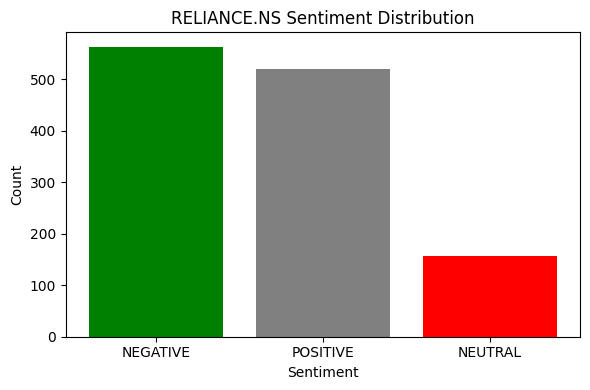

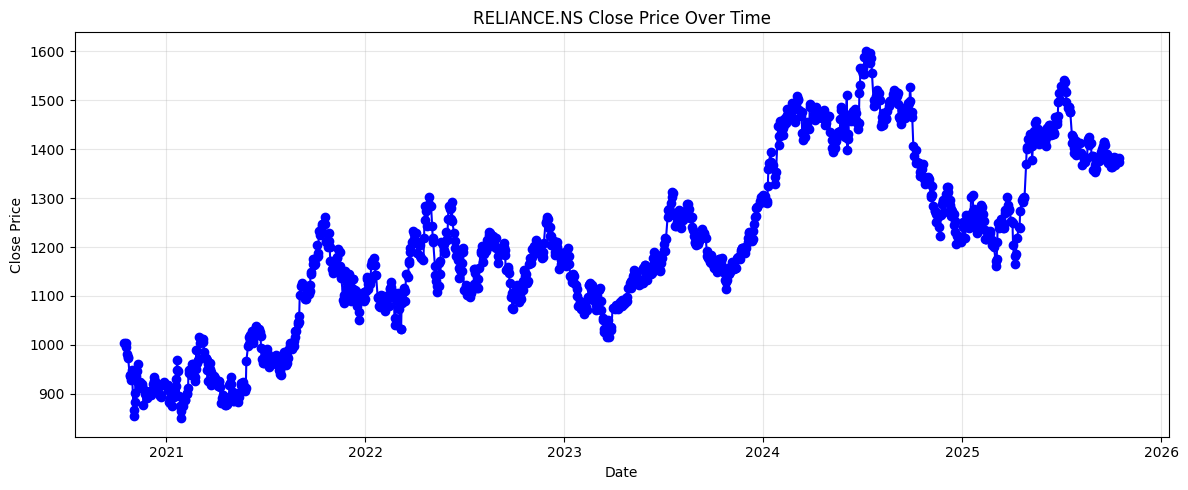

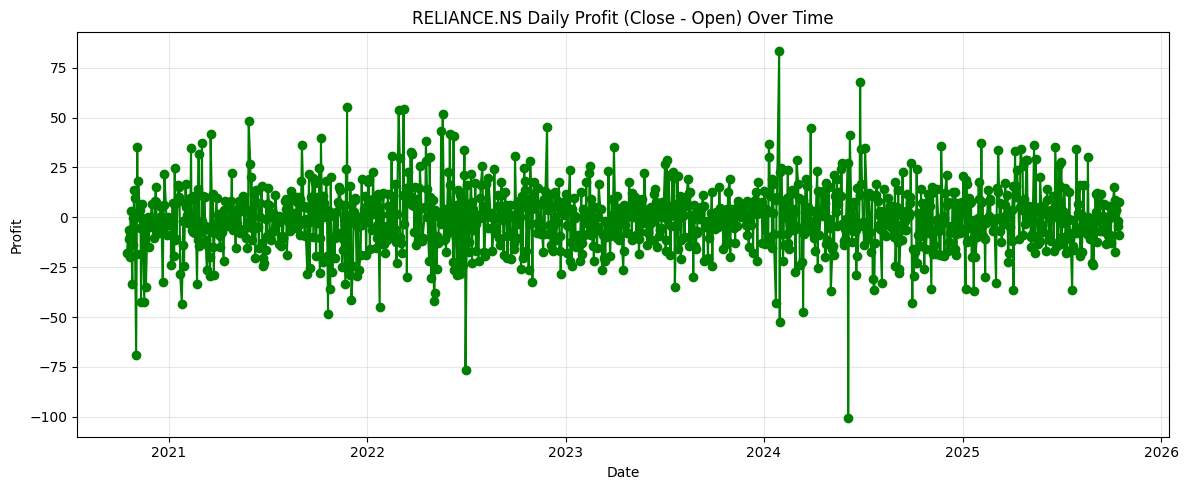

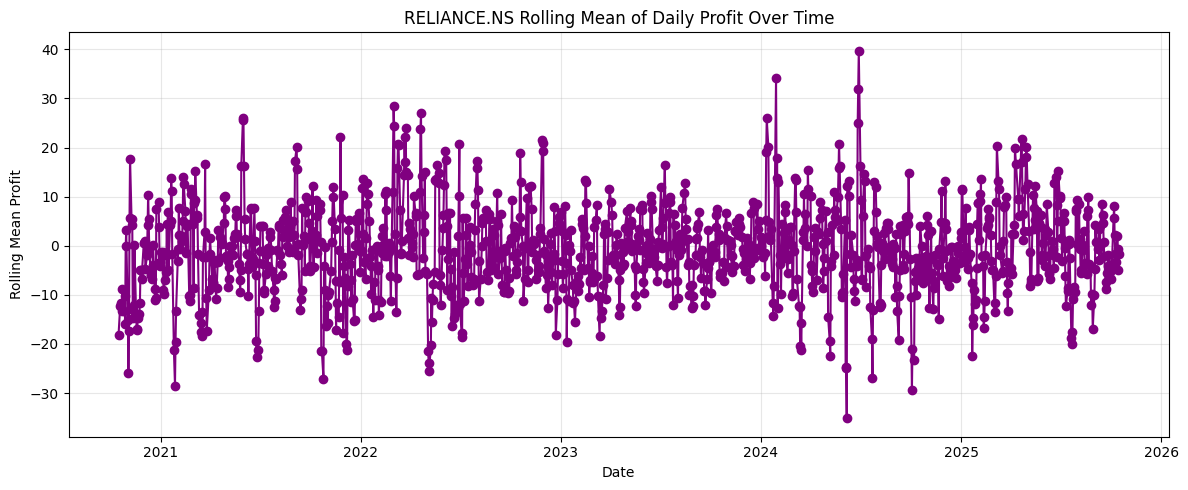

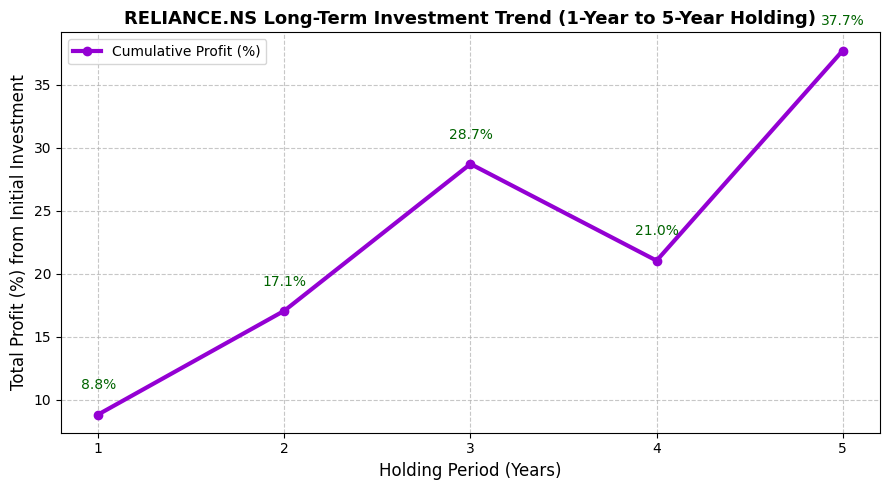

Completed processing RELIANCE.NS

Processing: SBIN.NS
Completed processing SBIN.NS

Processing: TCS.NS
Completed processing TCS.NS


In [45]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_stock(df2, ticker='RELIANCE.NS'):
    """
    Analyze all tickers in df2 but show plots only for the specified ticker (default: RELIANCE.NS)
    """

    # Normalize for case-insensitive comparison
    ticker = ticker.strip().upper()

    # Get all unique tickers
    tickers = df2['Ticker'].unique() if 'Ticker' in df2.columns else [ticker]

    for t in tickers:
        print(f"\nProcessing: {t}")
        t_clean = str(t).strip().upper()

        # Filter for the current ticker
        df_t = df2[df2['Ticker'] == t].copy() if 'Ticker' in df2.columns else df2.copy()

        if df_t.empty:
            print(f"⚠️ Skipping {t} — no data available.")
            continue

        # Ensure Date column or use index
        if 'Date' in df_t.columns:
            df_t['Date'] = pd.to_datetime(df_t['Date'], errors='coerce')
            df_t = df_t.dropna(subset=['Date']).sort_values('Date')
        else:
            df_t = df_t.sort_index()
            df_t.index = pd.to_datetime(df_t.index)
            df_t['Date'] = df_t.index

        if df_t.empty:
            print(f"⚠️ Skipping {t} — invalid or missing dates.")
            continue

        # Profit Calculations
        df_t['Profit'] = df_t['Close'] - df_t['Open']
        df_t['ProfitRolling'] = df_t['Profit'].rolling(window=3, min_periods=1).mean()

        # --- Yearly Investment Trend ---
        df_t = df_t.set_index('Date').sort_index()
        if df_t['Close'].empty:
            print(f"⚠️ Skipping {t} — no closing price data.")
            continue

        start_price = df_t['Close'].iloc[0]
        yearly_close = df_t['Close'].resample('Y').last()

        years = [1, 2, 3, 4, 5]
        profits = []
        for year in years:
            if len(yearly_close) > year:
                profit = ((yearly_close.iloc[year] - start_price) / start_price) * 100
                profits.append(profit)
            else:
                profits.append(None)

        # Only plot for the selected ticker
        if t_clean == ticker:
            print(f"Showing plots for {t}")

            # Sentiment Distribution
            if 'Sentiment' in df_t.columns and not df_t['Sentiment'].isnull().all():
                sentiment_counts = df_t['Sentiment'].value_counts()
                plt.figure(figsize=(6,4))
                plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'grey', 'red'])
                plt.title(f"{t} Sentiment Distribution")
                plt.xlabel("Sentiment")
                plt.ylabel("Count")
                plt.tight_layout()
                plt.show()

            # Close Price Over Time
            plt.figure(figsize=(12,5))
            plt.plot(df_t.index, df_t['Close'], marker='o', color='blue')
            plt.title(f"{t} Close Price Over Time")
            plt.xlabel("Date")
            plt.ylabel("Close Price")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Daily Profit
            plt.figure(figsize=(12,5))
            plt.plot(df_t.index, df_t['Profit'], marker='o', color='green')
            plt.title(f"{t} Daily Profit (Close - Open) Over Time")
            plt.xlabel("Date")
            plt.ylabel("Profit")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Rolling Mean of Profit
            plt.figure(figsize=(12,5))
            plt.plot(df_t.index, df_t['ProfitRolling'], marker='o', color='purple')
            plt.title(f"{t} Rolling Mean of Daily Profit Over Time")
            plt.xlabel("Date")
            plt.ylabel("Rolling Mean Profit")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

            # Long-Term Investment Trend
            if any(p is not None for p in profits):
                plt.figure(figsize=(9,5))
                plt.plot(years, profits, marker='o', color='darkviolet', linewidth=3, label='Cumulative Profit (%)')
                plt.title(f"{t} Long-Term Investment Trend (1-Year to 5-Year Holding)", fontsize=13, fontweight='bold')
                plt.xlabel("Holding Period (Years)", fontsize=12)
                plt.ylabel("Total Profit (%) from Initial Investment", fontsize=12)
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.xticks(years)
                plt.legend()

                for i, val in enumerate(profits):
                    if val is not None:
                        plt.text(years[i], val + 2, f"{val:.1f}%", ha='center', fontsize=10, color='darkgreen')

                plt.tight_layout()
                plt.show()

        print(f"Completed processing {t}")

analyze_stock(df2)

#Analysis

#Plot 2.

1. X-axis (Date)

The horizontal axis represents time, from around 2020 to 2025.

The dates appear at regular intervals and are rotated for readability.

2. Y-axis (Close Price)

The vertical axis represents the closing stock price, ranging roughly from 850 to 1600 INR.

3. Trend Interpretation

2020–2021: The price starts around ₹1000, dips below ₹900, indicating a downtrend.

2021–2022: Gradual recovery and upward movement, reaching about ₹1200 — likely due to market recovery post-pandemic.

2022–2023: Some fluctuations between ₹1100–₹1250 — a sideways trend.

2023–2024: Strong uptrend, prices peak around ₹1500–₹1600, possibly due to positive business growth or favorable market sentiment.

2024–2025: Noticeable volatility and a downward correction toward ₹1300–₹1400 — suggesting either profit-taking or broader market weakness.

4. Data Points

Each blue point represents a daily (or periodic) closing price.

The dense clustering shows frequent trading days with visible short-term volatility.

💡 5. Overall Summary

Over five years, Reliance’s stock shows a long-term uptrend, despite short-term fluctuations.

The price roughly increased by 40–50% from early 2020 to 2025.

This pattern is typical of cyclical growth: steady gains with periods of consolidation or correction.


#Plot3.

1. Axes

X-axis (Date):
Represents time, from 2020 to 2025.

Y-axis (Profit):
Represents the daily price difference (₹) — how much the stock price rose or fell in a single day.

2. Meaning of Values

Positive values (above 0) → Stock closed higher than it opened → Daily gain.

Negative values (below 0) → Stock closed lower than it opened → Daily loss.

3. Pattern Interpretation

The plot fluctuates sharply around zero, meaning Reliance’s daily price changes are balanced between small gains and losses.

The majority of daily changes seem to be within ±25 INR, showing moderate volatility.

There are occasional large spikes:

Positive spikes (up to +80 INR) show strong bullish days — possibly due to good news, results, or market momentum.

Negative spikes (down to −100 INR) indicate sharp declines — perhaps caused by negative market sentiment or external events.

These spikes occur sporadically across years, not concentrated in one period, implying periodic market reactions rather than a trend.

4. Volatility Insights

From 2020 to 2025, volatility appears fairly consistent, suggesting Reliance’s stock had stable daily fluctuations without major long-term increase in day-to-day risk.

Some isolated large profit/loss days indicate news-driven or event-driven volatility, not systemic instability.

5. Summary

Reliance.NS shows regular daily price swings around zero (typical of an actively traded stock).

Most days: small profits/losses.

Some days: large deviations — reflecting significant market events.

The overall pattern indicates steady market activity and controlled volatility over time.

#Plot4.

1. Axes

X-axis (Date):
Timeline from 2020 to 2025.

Y-axis (Rolling Mean Profit):
The average daily profit/loss over a moving window (e.g., 7 or 14 days, depending on your code).

Positive values → average daily gain over the window.

Negative values → average daily loss over the window.

2. What the Rolling Mean Shows

The rolling mean smooths out daily noise to reveal short-term trends in profit or loss.
It helps you see when the stock consistently gained or lost value over several days in a row.

3. Interpretation

Throughout 2020–2025, the rolling mean fluctuates closely around zero, indicating:

The average short-term daily profit/loss stays small.

There is no persistent long-term upward or downward bias — i.e., daily profits and losses tend to cancel out over time.

Occasional upward spikes (up to +30 to +40 INR):
Indicate short-term bullish streaks where the stock consistently closed above its opening price.

Occasional downward spikes (down to −30 INR):
Represent short-term bearish streaks with consistent daily losses.

Around 2023–2024, a few sharp peaks (both up and down) appear — this suggests higher volatility periods, where the stock saw larger consecutive moves.

4. Overall Insight

The rolling mean oscillates around zero, confirming that Reliance.NS’s day-to-day performance is mean-reverting — short bursts of profit/loss but no sustained trend.

The volatility increased slightly around 2023–2024 (wider swings in rolling mean), likely due to market or company-specific events.

No clear directional bias → Stock remains fundamentally stable with balanced buying and selling pressures over time.

| Observation             | Meaning                               |
| ----------------------- | ------------------------------------- |
| Rolling mean near 0     | No consistent daily profit/loss trend |
| Positive spikes         | Short-term upward momentum            |
| Negative spikes         | Short-term downward momentum          |
| Larger swings post-2023 | Increased short-term volatility       |

#Plot5.

Overview

The y-axis shows total profit (%) relative to the initial investment.

The x-axis represents holding period in years (from 1 to 5).

The purple line with dots represents cumulative profit (%) for each holding period.

The final value (top right) shows 32.3% total profit after 5 years.

| Holding Period | Total Profit (%) | Observation                                                                              |
| -------------- | ---------------- | ---------------------------------------------------------------------------------------- |
| **1 Year**     | **5.8%**         | Small short-term gain — modest growth in the first year.                                 |
| **2 Years**    | **13.8%**        | Profit more than doubled — steady medium-term performance.                               |
| **3 Years**    | **25.1%**        | Strong compounding effect — best return before a slight dip.                             |
| **4 Years**    | **17.6%**        | Slight decline — could be due to temporary market correction or weaker performance year. |
| **5 Years**    | **32.3%**        | Recovery and highest overall return — long-term investors benefited most.                |


Trend Insights

The general trend is upward, indicating positive long-term returns.

The dip at year 4 suggests there may have been a temporary market slowdown or correction.

Patience pays off — the 5-year holding period significantly outperforms shorter periods.

## Conclusion

This notebook demonstrates the design and implementation of an **Agentic AI-based financial analysis system** that automates the process of investment research. The system incorporates three major elements:

1. **Agent Functions:**  
   The agent autonomously plans, executes, and refines research tasks, integrating price data, news content, and heuristic evaluation within a unified framework.

2. **Workflow Patterns:**  
   All three patterns—Prompt Chaining, Routing, and Evaluator–Optimizer—are represented in the workflow, showing how an AI system can reason across steps, direct specialized analyses, and improve through iterative feedback.

3. **Code Quality and Structure:**  
   The codebase is modular, reproducible, and well-commented, demonstrating clear data flow and adherence to sound programming practices.

The agent’s behavior can be extended with real API integrations (e.g., NewsAPI, FRED, SEC EDGAR) to support large-scale financial intelligence gathering. Future improvements could include integrating a reinforcement learning loop for dynamic portfolio recommendations or LLM-driven natural language evaluation for enhanced interpretability.
